# Goal

* Assessing the error in taxon abundances when using qPCR data + 16S sequence relative abundances to determine taxon proportional absolute abundances

# Init

In [1]:
%load_ext rpy2.ipython

In [2]:
%%R
library(ggplot2)
library(dplyr)
library(tidyr)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘dplyr’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:stats’:

    filter, lag


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [3]:
def neg_binom_err(m, r, negs=False):
    """Adding negative binomial distribuiton error, where variance
    scales more with the mean than a poisson distribution if (r < inf).

    Parameters
    ----------
    m : float
        Mean value
    r : float
        Negative binomial dispersion parameter
    negs : bool
        Negative values allowed? (otherwise 0)
    """
    sigma = np.sqrt(m + m**2 / r)
    x =  np.random.normal(m, sigma)
    if negs==False and x < 0:
        x = 0
    return x

# Making dataset

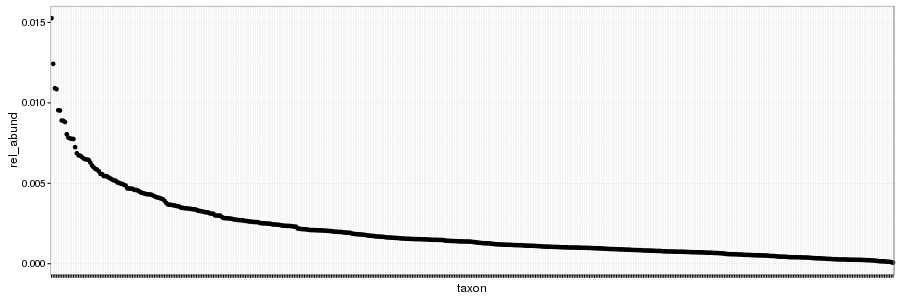

In [4]:
%%R -w 900 -h 300

n = 500
meanlog = 0.5
sdlog = 1

comm = rlnorm(n, meanlog, sdlog)
comm = data.frame(1:length(comm), comm)
colnames(comm) = c('taxon', 'count')

comm = comm %>%
    mutate(taxon = as.character(taxon)) %>%
    group_by() %>%
    mutate(rel_abund = count / sum(count)) %>%
    ungroup()

comm$taxon = reorder(comm$taxon, -comm$rel_abund)

ggplot(comm, aes(taxon, rel_abund)) +
    geom_point() +
    theme_bw() +
    theme(
        axis.text.x = element_blank()
    )

# Simulating qPCR data

In [62]:
%%R

exp_series = function(e_start, e_end){
    sapply(e_start:e_end, function(x) cumprod(rep(10, x))[x])
}

neg_binom_err = function(m, r, n_reps=1, negs=FALSE){
    sigma = sqrt(m + (m**2 / r))
    print(c(m, sigma))
    x = rnorm(n_reps, m, sigma)
    if (negs==FALSE & x < 0){
        x[x<0] = 0
    }
    return(x)
}


In [63]:
%%R
# test
exp_series(1,3)

neg_binom_err(1e9, 0.5, n_reps=1)

[1] 1000000000 1414213563
[1] 1318057825


In [36]:
%%R

# params
r = 0.5
n_reps = 3
total_copies = exp_series(6, 10)

# qPCR 
sapply(total_copies, function(x) qPCR(x, r=r, n_reps=n_reps))

        [,1]     [,2]      [,3]       [,4]        [,5]
[1,] 2343453        0  24214819 2383267265 28595805348
[2,]       0  1555189 110732035          0           0
[3,] 1951529 16729086         0  824000453  1595748080
